The goal of this notebook is to present an initial EDA regarding the data of **OSIC Pulmonary Fibrosis Progression** Kaggle challenge.

Furthermore, in the end of the notebook, a **XGBoost** model is trained with the goal of predicting the FVC.This simple approach only takes in consideration the Patient's data (and not the CT scans), therefore, it is just an introductory and baseline approach, that shoud be improved in the future.

Kaggle Challenge Link: https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from collections import Counter
import pydicom
import os
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu, median
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        if 'ID00419637202311204720264' in dirname:
#            print(os.path.join(dirname, filename))
            

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [47]:
train_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv')


In [48]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [49]:
test_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


## Exploratory Data Analysis

### Variables Distribution

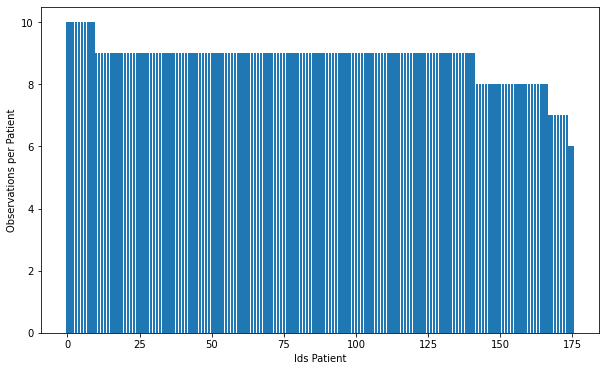

In [50]:
#Patient

patients_dist = Counter(train_df['Patient'].values).most_common()

plt.figure(figsize=(10, 6))
plt.bar(range(len(patients_dist)), list(dict(patients_dist).values()))

plt.xlabel('Ids Patient')
plt.ylabel('Observations per Patient')
plt.show()


In [51]:
info_df = pd.DataFrame(columns=['Patient','Age','Sex', 'SmokingStatus'])

for ind, row in train_df.groupby('Patient'):
    new_row = {'Patient': ind, 'Age': row.iloc[0]['Age'], 'Sex': row.iloc[0]['Sex'], 'SmokingStatus': row.iloc[0]['SmokingStatus']}
    info_df.loc[len(info_df)] = new_row
    
    
info_df

,Patient,Age,Sex,SmokingStatus
0,ID00007637202177411956430,79,Male,Ex-smoker
1,ID00009637202177434476278,69,Male,Ex-smoker
2,ID00010637202177584971671,60,Male,Ex-smoker
3,ID00011637202177653955184,72,Male,Ex-smoker
4,ID00012637202177665765362,65,Male,Never smoked
...,...,...,...,...
171,ID00419637202311204720264,73,Male,Ex-smoker
172,ID00421637202311550012437,68,Male,Ex-smoker
173,ID00422637202311677017371,73,Male,Ex-smoker
174,ID00423637202312137826377,72,Male,Ex-smoker


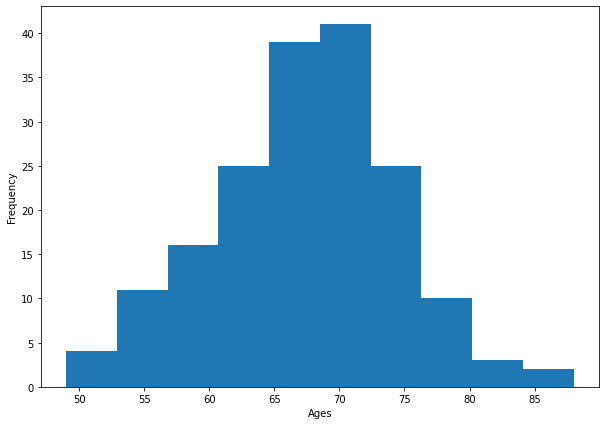

In [52]:
#Age

plt.figure(figsize = (10, 7))
plt.hist(info_df['Age'], 10)
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.show()

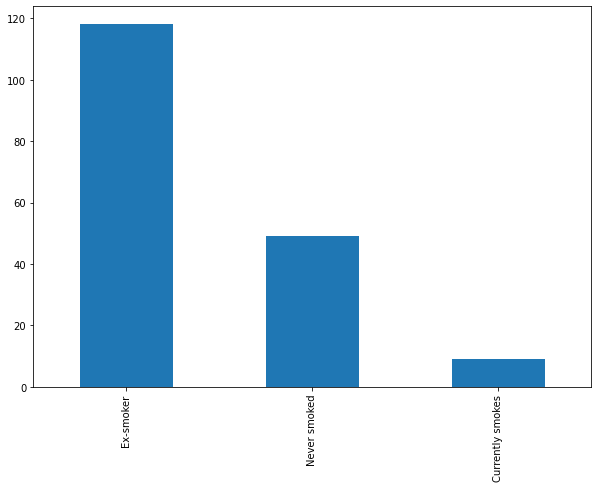

In [53]:
#SmokingStatus

plt.figure(figsize = (10, 7))
info_df['SmokingStatus'].value_counts().plot(kind='bar');
plt.show()

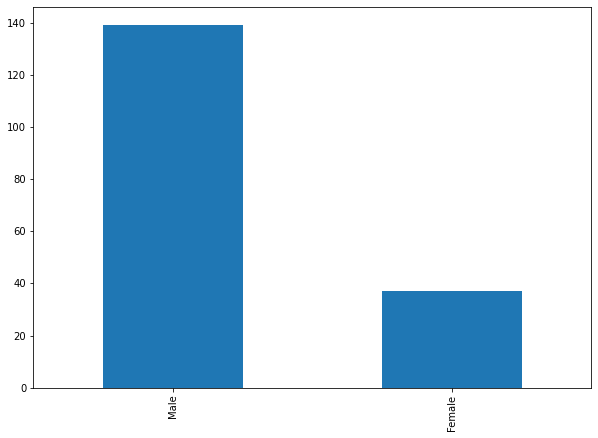

In [54]:
#Gender

plt.figure(figsize = (10, 7))
info_df['Sex'].value_counts().plot(kind='bar');
plt.show()

In [55]:
train_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


### FVC vs Weeks

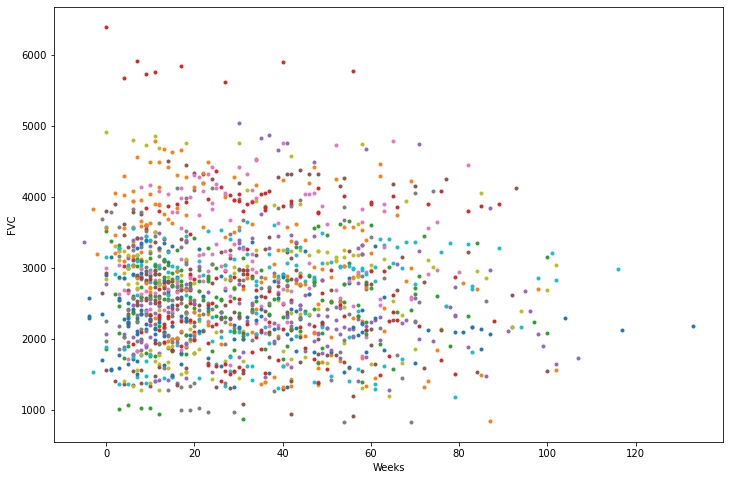

In [56]:
plt.figure(figsize=(12, 8))

for ind, patient_data in train_df.groupby('Patient'):
    plt.plot(patient_data['Weeks'], patient_data['FVC'], '.', label=ind)

plt.xlabel('Weeks')
plt.ylabel('FVC')
plt.show()

As observed, there is not a clear pattern on the FVC values over the number of weeks. This is understandable, as for each patient, the week = 0 correspond to a different stage of the decline in the lung function. This means that the weeks information cannot be crossed between different patients.

### FVC evolution over time

Currently smokes : blue lines
Ex-smoker : red lines
Never smoked : green lines


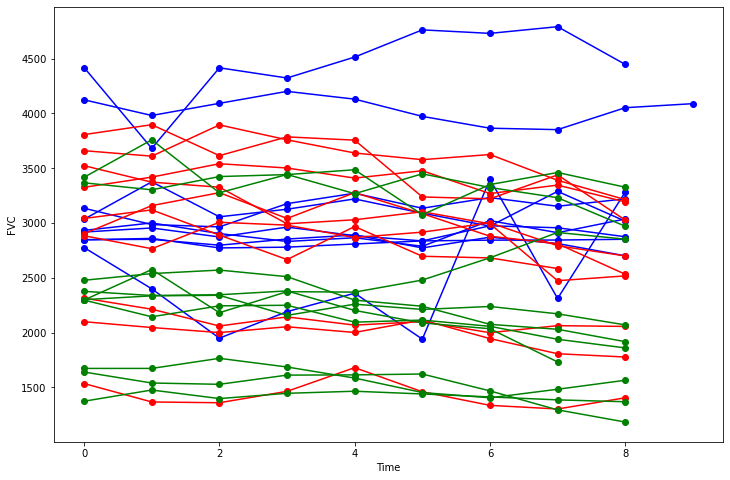

In [57]:
plt.figure(figsize=(12, 8))

c = ['blue', 'red', 'green']
i = 0

for ind_smoke, status_data in train_df.groupby('SmokingStatus'):
    counter = 0
    print(ind_smoke,':', c[i], 'lines')
    
    for ind, patient_data in status_data.groupby('Patient'):
        plt.plot(range(len(patient_data)), patient_data['FVC'], 'o-', label=ind_smoke, color=c[i])

        counter += 1

        if counter == 10:
            break
    i += 1

plt.xlabel('Time')
plt.ylabel('FVC')
#plt.legend()
plt.show()

Overral, there is a decreasing trend on the FVC value over time

### Initial value of FVC

In [58]:
c = ['blue', 'red', 'green']
i = 0

first_FVC = {}
for ind_smoke, status_data in train_df.groupby('SmokingStatus'):
    
    first_FVC[ind_smoke] = []
    for ind, patient_data in status_data.groupby('Patient'):
        first_FVC[ind_smoke].append(patient_data.iloc[0]['FVC'])


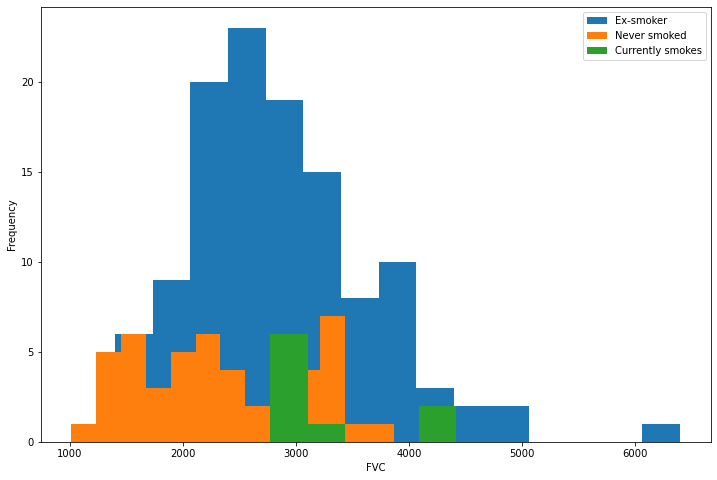

In [59]:
plt.figure(figsize=(12, 8))

plt.hist(first_FVC['Ex-smoker'], bins = 15, label='Ex-smoker')
plt.hist(first_FVC['Never smoked'], bins = 15, label='Never smoked')
plt.hist(first_FVC['Currently smokes'], bins = 5, label='Currently smokes')


plt.legend()
plt.xlabel('FVC')
plt.ylabel('Frequency')
plt.show()

By analysing the first value of FVC of the different types of person (regarding the smoking habits), we can see that, generically, the FVC values are higher in the *Ex-smoker* and *Currently smokes* persons

### FVC vs Percent

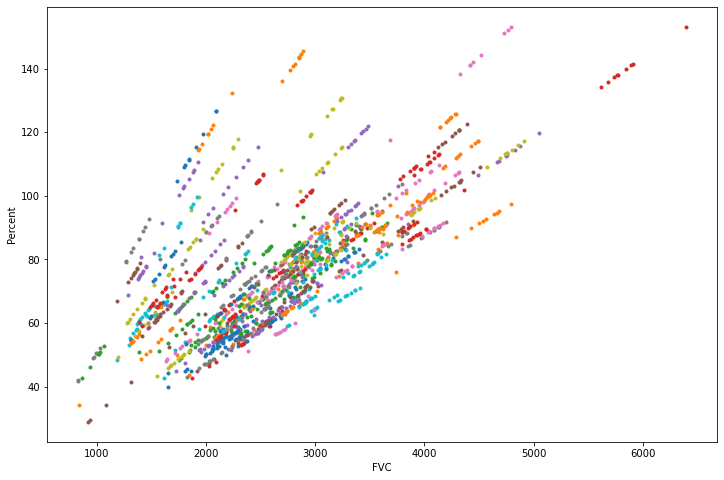

In [60]:

plt.figure(figsize=(12, 8))

for ind, patient_data in train_df.groupby('Patient'):
    plt.plot(patient_data['FVC'], patient_data['Percent'], '.', label=ind)

plt.xlabel('FVC')
plt.ylabel('Percent')
plt.show()

As we can see, there is a linear relationship between the FVC and Percent (which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics). This relationship may help to model the FVC

## CT scans Analysis

### Vizualize the CTs

In [61]:
ct_patient = 'ID00007637202177411956430'
#ct_patient = 'ID00015637202177877247924'

img_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/osic-pulmonary-fibrosis-progression/train'):
    if ct_patient in dirname:
        filenames.sort(key = lambda x: int(x.split('.')[0]))
        for filename in filenames:
            img_paths.append(os.path.join(dirname, filename))

#img_paths

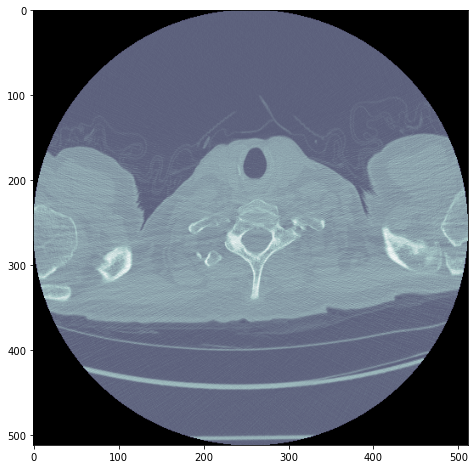

In [62]:
#First image

ds = pydicom.dcmread(img_paths[0])

plt.figure(figsize = (8,8))
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

### CT Animation

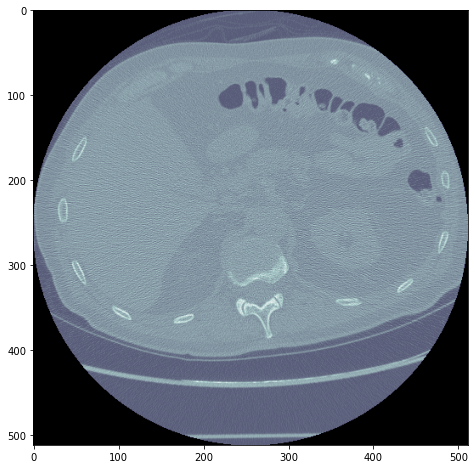

In [63]:
#Sequence of images
from IPython.display import clear_output


for i in img_paths:
    plt.figure(figsize = (8,8))
    ds = pydicom.dcmread(i)
    
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.pause(0.1)
    clear_output(wait=True)


### Image Segmentation

The goal is to isolate the lungs region

In [64]:
#from https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

patient = load_scan('/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/')
imgs = get_pixels_hu(patient)

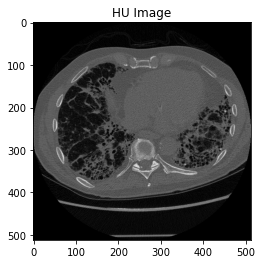

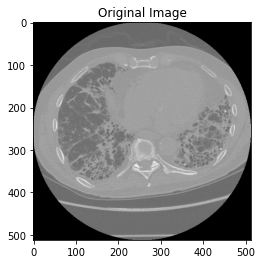

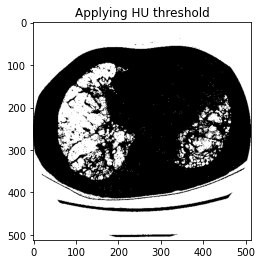

In [65]:
index_example = 20

plt.imshow(imgs[index_example], cmap='gray')
plt.title('HU Image')
plt.show()

ds = pydicom.dcmread(img_paths[index_example])
plt.imshow(ds.pixel_array, cmap='gray')
plt.title('Original Image')
plt.show()

new_img = imgs[index_example] < -500

plt.imshow(new_img, cmap='gray')
plt.title('Applying HU threshold')
plt.show()



As we can see in the last image, the outside region is being considered as lung section, due to the HU pixels values. Therefore, a mask will be applied to filter outside boundary section.

Then the lung volume will be computed (as suggested in https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727)

Lung Volume:  22260.66144071616


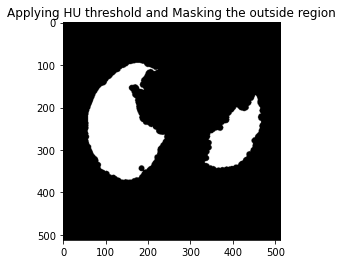

In [66]:
lungs = median(clear_border(new_img))
lungs = morphology.binary_closing(lungs, selem=morphology.disk(7))
mask = binary_fill_holes(lungs)


def compute_lung_volume(ds, mask):
    return np.sum(mask) * float(ds.SliceThickness) * ds.PixelSpacing[0] * ds.PixelSpacing[1]


print("Lung Volume: ", compute_lung_volume(ds, mask))

plt.imshow(mask, cmap='gray')
plt.title('Applying HU threshold and Masking the outside region')
plt.show()

## Model to predict FVC

A XGBoost model will be trained to try predicting the FVC, only using the patients data (that is, without analysing the CT images).

Some preprocessing steps will be applied, like oversamling, features categorization and data normalization.

In [67]:
#oversampling, assuming that FVC follows a Linear Regression according to the Week value

for i, d in train_df.groupby('Patient'):
    
    week_data = d['Weeks']
    
    
    xx = [c for c in range(min(week_data), max(week_data)) if c not in week_data]
    
    reg = LinearRegression().fit(week_data.values.reshape(-1,1), d['FVC'].values)
    res = reg.predict(np.array(xx).reshape(-1,1))
    
    for j in range(len(xx)):
        train_df.loc[len(train_df)] = [d.iloc[0]['Patient'], xx[j], res[j], d.iloc[0]['Percent'], d.iloc[0]['Age'], d.iloc[0]['Sex'], d.iloc[0]['SmokingStatus']]


In [68]:
#Transforming Training Set
X_train = pd.concat([train_df, test_df], axis = 0, ignore_index = True)

y_train = X_train['FVC']
X_train = X_train.drop(['FVC', 'Percent'], axis = 1)

X_train.reset_index(inplace=True, drop=True)


#Transforming Test Set
X_test = pd.DataFrame(columns = ['Patient', 'Weeks', 'Age', 'Sex', 'SmokingStatus'])

for ind, row in test_df.iterrows():
    
    for i in range(-12, 133+1):
        new_row = [row.Patient, i, row.Age, row.Sex, row.SmokingStatus]
        X_test.loc[len(X_test)] = new_row

In [69]:

categorical_vars = ['Patient', 'Sex', 'SmokingStatus']
int_vars = ['Weeks', 'Age']


#Categorize features

encoder = OneHotEncoder(categories = 'auto', handle_unknown = 'ignore', sparse = False)
encoder.fit(X_train[categorical_vars])

X_train = pd.concat([X_train.drop(categorical_vars, axis = 1), pd.DataFrame(encoder.transform(X_train[categorical_vars]), 
                                           columns = encoder.get_feature_names())], axis=1, sort=False)
X_test = pd.concat([X_test.drop(categorical_vars, axis = 1), pd.DataFrame(encoder.transform(X_test[categorical_vars]),
                                         columns = encoder.get_feature_names())], axis=1, sort=False)


X_test.Weeks = pd.to_numeric(X_test.Weeks)
X_test.Age = pd.to_numeric(X_test.Age)



#Normalization

sc = StandardScaler()
sc.fit(X_train[int_vars])
X_train[int_vars] = sc.transform(X_train[int_vars])
X_test[int_vars] = sc.transform(X_test[int_vars])


In [70]:
display(X_train.head())
display(X_test.head())

,Weeks,Age,x0_ID00007637202177411956430,x0_ID00009637202177434476278,x0_ID00010637202177584971671,x0_ID00011637202177653955184,x0_ID00012637202177665765362,x0_ID00014637202177757139317,x0_ID00015637202177877247924,x0_ID00019637202178323708467,...,x0_ID00419637202311204720264,x0_ID00421637202311550012437,x0_ID00422637202311677017371,x0_ID00423637202312137826377,x0_ID00426637202313170790466,x1_Female,x1_Male,x2_Currently smokes,x2_Ex-smoker,x2_Never smoked
0,-1.931121,1.686226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.530892,1.686226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-1.441952,1.686226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-1.353012,1.686226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-1.264072,1.686226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


,Weeks,Age,x0_ID00007637202177411956430,x0_ID00009637202177434476278,x0_ID00010637202177584971671,x0_ID00011637202177653955184,x0_ID00012637202177665765362,x0_ID00014637202177757139317,x0_ID00015637202177877247924,x0_ID00019637202178323708467,...,x0_ID00419637202311204720264,x0_ID00421637202311550012437,x0_ID00422637202311677017371,x0_ID00423637202312137826377,x0_ID00426637202313170790466,x1_Female,x1_Male,x2_Currently smokes,x2_Ex-smoker,x2_Never smoked
0,-2.286880,0.833319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-2.242410,0.833319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-2.197940,0.833319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-2.153471,0.833319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-2.109001,0.833319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [71]:
#Train the model

parameters = {
    'max_depth': [5, 10],
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.005]
}

#Cross Validation
grid_search = GridSearchCV(
    estimator=xgboost.XGBRegressor(random_state = i),
    param_grid=parameters,
    n_jobs = 5,
    cv = 5
)

grid_search.fit(X_train, y_train)
print("Best Parms", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_    

Best Parms {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
Best Score:  0.8309377308861915


Next Steps/Future Work:
- Compute the **Confidence** in each prediction
- Create **submission.csv** file
- Possibly, incorporate the CT data in the model
    